# Brewing Data Cup

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
active_promos = pd.read_csv('data/active_promos.csv')
active_promos['Fecha_Desde'] = pd.to_datetime(active_promos['Fecha_Desde'], format='%Y-%m-%d')
active_promos['Fecha_Hasta'] = pd.to_datetime(active_promos['Fecha_Hasta'], format='%Y-%m-%d')
active_promos['dias_promo'] = (active_promos['Fecha_Hasta']-active_promos['Fecha_Desde']).dt.days.astype('int64')
active_promos['Fecha_Desde'] = active_promos.Fecha_Desde.dt.year*100+active_promos.Fecha_Desde.dt.month
active_promos['Fecha_Hasta'] = active_promos.Fecha_Hasta.dt.year*100+active_promos.Fecha_Hasta.dt.month
active_promos['duracion'] = active_promos['Fecha_Hasta']-active_promos['Fecha_Desde']

executed_promos = pd.read_csv('data/executed_promos.csv')

clients = pd.read_csv('data/clients_attributes.csv')
clients['FechaAltaCliente'] = pd.to_datetime(clients['FechaAltaCliente'], format='%Y-%m-%d')
clients['FechaAltaCliente'] = clients.FechaAltaCliente.dt.year*100+clients.FechaAltaCliente.dt.month

sales = pd.read_csv('data/sales.csv',encoding='ISO-8859-1')
sales = sales.dropna()
sales['fecha'] = sales.Año*100+sales.Mes
sales.drop(columns=['Año','Mes'],inplace=True)

test = pd.read_csv('data/test.csv')

In [3]:
executed_promos['target'] = 1
df = active_promos.merge(executed_promos,on=['CodigoDC','Cliente','Marca','Cupo'],how='left').replace(np.nan,0)

In [4]:
rechazados = []
agr = {'target':['count','sum','mean']}
ext = []
agre = {'CodigoDC':'nunique','duracion':'mean'}

for i in list(df.Fecha_Desde.unique()):
    aux = df[df.Fecha_Hasta < i].groupby(['Cliente','Marca','Cupo']).agg(agr)
    aux.columns = [j+'_'+k for j,k in aux.columns]
    aux['prom_rechazo'] = aux['target_count'] - aux['target_sum']
    aux.drop(columns=['target_count','target_sum'],inplace=True)
    aux['Fecha_Desde'] = i
    rechazados.append(aux)
    
    aux2 = df[df.Fecha_Desde == i].groupby(['Cliente','Marca','Cupo']).agg(agre)
    aux2.columns = ['nproms_ofre','duracion_mes_mean']
    aux2['Fecha_Desde'] = i
    ext.append(aux2)
    
hist_rech = pd.concat(rechazados)
agre_1 = pd.concat(ext)
df = df.merge(hist_rech,on=['Cliente','Marca','Cupo','Fecha_Desde'],how='left')
df = df.merge(agre_1,on=['Cliente','Marca','Cupo','Fecha_Desde'],how='left')
df = df.replace(np.nan,0)

In [5]:
adi = []
agreg = {'CodigoDC':'nunique',
           'target':['max','mean'],
           'Fecha_Desde':'nunique',
           'target_mean':['max','mean'],
           'dias_promo':['mean','max','min','std']}

for i in list(df.Fecha_Desde.unique()):
    aux3 = df[df.Fecha_Desde<i].groupby(['Cliente','Marca','Cupo']).agg(agreg)
    aux3.columns = [j+'_'+k for j,k in aux3.columns]
    aux3['Fecha_Desde'] = i
    aux3 = aux3.reset_index()
    adi.append(aux3)
    
agre_2 = pd.concat(adi)
df = df.merge(agre_2,on=['Cliente','Marca','Cupo','Fecha_Desde'],how='left')
df = df.replace(np.nan,0)
#df

In [ ]:
productos_train=list(active_promos['producto_encoded'].unique())

agg_cliente={'ClaseEnvase':[f],
             'SegmentoPrecio':['mean'],
             'producto_encoded':['nunique',f],
             'Anio_Mes':['max','min'],
             'Nr':['median','max','min','std'],
             'Hl':['mean','max','min','std'],
             'Dcto':['mean','max','min','std'],
             'riesgo_producto':['mean', 'max', 'min', 'std']}

agg_producto={'Cliente':['nunique'],
            'ClaseEnvase':[f],
             'SegmentoPrecio':['mean'],
             #'Anio_Mes':['nunique','max','min'],
             'Nr':['median','max','min','std',cuenta_neg],
             'Hl':['mean','max','min','std'],
             'Dcto':['mean','max','min','std',cuenta_desc],
              'riesgo_producto':['mean', 'max', 'min', 'std']}

agg_cliente_producto={'Anio_Mes':['max','min'],
             'Nr':['median','max','min','std'],
             'Hl':['mean','max','min','std'],
             'Dcto':['mean','max','min','std'],
            'riesgo_producto':['mean', 'max', 'min', 'std']}

l_1=[]
l_2=[]
l_3=[]

for i in tqdm_notebook(list(active_promos.aniomes_desde.unique())):
    
    t1=sales[sales.Anio_Mes<i].groupby('Cliente').agg(agg_cliente)
    t1.columns=['cliente_'+str(a)+'_'+str(b) for a,b in t1.columns]
    t1=t1.reset_index()
    t1['aniomes_desde']=i

    t2=sales[(sales.producto_encoded.isin(productos_train)) & (sales.Anio_Mes<i)].groupby(['producto_encoded']).agg(agg_producto)
    t2.columns=['producto_'+str(a)+'_'+str(b) for a,b in t2.columns]
    t2=t2.reset_index()
    t2['aniomes_desde']=i

    t3=sales[(sales.producto_encoded.isin(productos_train)) & (sales.Anio_Mes<i)].groupby(['Cliente','producto_encoded']).agg(agg_cliente_producto)
    t3.columns=['cliente_producto_'+str(a)+'_'+str(b) for a,b in t3.columns]
    t3=t3.reset_index()
    t3['aniomes_desde']=i
    
    l_1.append(t1)
    l_2.append(t2)
    l_3.append(t3)
    
g_cliente=pd.concat(l_1)
g_producto=pd.concat(l_2)
g_cliente_producto=pd.concat(l_3)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f80077d09d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f80077dd290>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f80077d0590>],
 'medians': [<matplotlib.lines.Line2D at 0x7f80077ddb50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f80077ddf90>],
 'means': []}

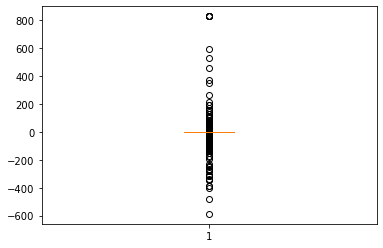

In [6]:
sales['riesgo_producto'] = (sales['Dcto'] / sales['Nr'])
sales.riesgo_producto = sales.riesgo_producto.fillna(0)
sales = sales.drop(sales[sales.riesgo_producto < -600].index)
sales = sales.drop(sales[sales.riesgo_producto > 1000].index)
plt.boxplot(sales.riesgo_producto)

In [7]:
master = []
ad = {'Hl':['sum','min','max','mean'],
     'Dcto':['sum','min','max','mean'],
     'Nr':['sum','min','max','mean']}

for i in list(df.Fecha_Desde.unique()):
    temp = sales[(sales.fecha<i)].groupby(['Cliente']).agg(ad)
    temp.columns = [str(j)+'_'+str(k) for j,k in temp.columns]
    temp['Fecha_Desde'] = i # Acumulado de ventas hasta antes de la Fecha_Desde de la promo
    master.append(temp)
acum_cliente = pd.concat(master).reset_index()
df = df.merge(acum_cliente,on=['Cliente','Fecha_Desde'],how='left')

In [8]:
df = df.merge(clients,on=['Cliente'],how='left')
df.head()

,CodigoDC,Marca,Cupo,Fecha_Desde,Fecha_Hasta,Cliente,dias_promo,duracion,target,target_mean_x,prom_rechazo,nproms_ofre,duracion_mes_mean,CodigoDC_nunique,target_max,target_mean_y,Fecha_Desde_nunique,target_mean_max,target_mean_mean,dias_promo_mean,dias_promo_max,dias_promo_min,dias_promo_std,Hl_sum,Hl_min,Hl_max,Hl_mean,Dcto_sum,Dcto_min,Dcto_max,Dcto_mean,Nr_sum,Nr_min,Nr_max,Nr_mean,FechaAltaCliente,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF
0,297601,29,9,201808,201808,3213,24,0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.00,0.01,0.62,0.096154,-128346.89,-22086.67,0.0,-1234.104712,3053627.15,3092.91,178134.55,29361.799519,201003,3,8,15,2,3,1
1,297601,29,9,201808,201808,3795,24,0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.99,0.03,0.98,0.203878,-248783.11,-70273.24,0.0,-5077.206327,3378290.77,-13347.44,284888.42,68944.709592,201004,3,10,6,2,3,1
2,297601,29,9,201808,201808,11816,24,0,1.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.44,0.01,7.13,0.576667,-452013.07,-137887.73,0.0,-5381.107976,14853188.88,1533.96,2199023.28,176823.677143,201710,3,7,12,2,3,1
3,298856,40,16,201808,201808,8444,7,0,1.0,0.0,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.37,0.01,1.08,0.191890,-802059.92,-50638.85,0.0,-6315.432441,5616765.42,604.52,245902.45,44226.499370,201509,5,27,18,2,2,1
4,309916,40,16,201808,201808,8488,7,0,1.0,0.0,0.0,2,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.65,0.00,4.25,0.315487,-746163.91,-109898.11,0.0,-6603.220442,10892596.84,2194.04,1309385.05,96394.662301,201509,3,10,16,2,2,0


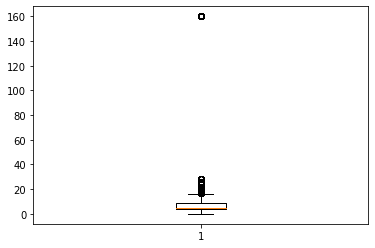

In [9]:
plt.boxplot(active_promos.dias_promo)
active_promos = active_promos.drop(active_promos[active_promos.dias_promo > 20].index)

In [10]:
df['producto_encoded']=df['Marca']*100+df['Cupo']

In [11]:
df=df.drop(columns='FechaAltaCliente')

In [87]:
df.drop(columns=['CodigoDC','target'],inplace=True)

In [88]:
train = df[df.Fecha_Desde<201908]
te = df[df.Fecha_Desde>=201908]

In [89]:
columnas_train=[x for x in train.columns if x!='target_mes']
X_train,X_test,y_train,y_test=train[columnas_train],te[columnas_train],train['target_mes'],te['target_mes']

In [90]:
from catboost import CatBoostClassifier

In [91]:
model=CatBoostClassifier(n_estimators=50)
model.fit(X_train,y_train)

Learning rate set to 0.5
0:	learn: 0.3847399	total: 37.3ms	remaining: 1.83s
1:	learn: 0.3469645	total: 71.1ms	remaining: 1.71s
2:	learn: 0.3328743	total: 102ms	remaining: 1.6s
3:	learn: 0.3146724	total: 141ms	remaining: 1.62s
4:	learn: 0.3088396	total: 175ms	remaining: 1.58s
5:	learn: 0.3040913	total: 217ms	remaining: 1.59s
6:	learn: 0.2999303	total: 257ms	remaining: 1.58s
7:	learn: 0.2975596	total: 294ms	remaining: 1.54s
8:	learn: 0.2951339	total: 330ms	remaining: 1.5s
9:	learn: 0.2931650	total: 365ms	remaining: 1.46s
10:	learn: 0.2919514	total: 400ms	remaining: 1.42s
11:	learn: 0.2899918	total: 442ms	remaining: 1.4s
12:	learn: 0.2890957	total: 479ms	remaining: 1.36s
13:	learn: 0.2872482	total: 517ms	remaining: 1.33s
14:	learn: 0.2859593	total: 553ms	remaining: 1.29s
15:	learn: 0.2847032	total: 593ms	remaining: 1.26s
16:	learn: 0.2838177	total: 630ms	remaining: 1.22s
17:	learn: 0.2832172	total: 672ms	remaining: 1.19s
18:	learn: 0.2809283	total: 710ms	remaining: 1.16s
19:	learn: 0.2780

In [92]:
from sklearn.metrics import roc_auc_score

In [93]:
preds=model.predict_proba(X_test)[:,-1]
roc_auc_score(y_test,preds)

0.7874397187909823

In [70]:
def plot_importances(model, X, n_features=-1):
    
    importances = model.feature_importances_
    indices = np.argsort(importances)
    if n_features!=-1:
        indices=indices[-n_features:]

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.barh(range(len(X.columns[indices])), importances[indices],
           align="center")
    # If you want to define your own labels,
    # change indices to a list of labels on the following line.
    plt.yticks(range(len(X.columns[indices])), X.columns[indices])
    plt.ylim([-1, len(X.columns[indices])])
    plt.show()

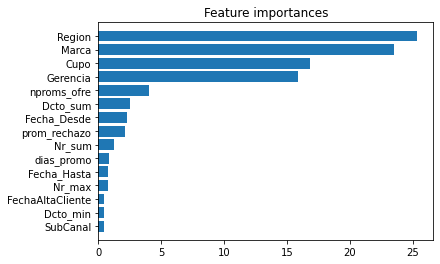

In [94]:
plot_importances(model,X_train,15)

In [34]:
sales.head()

,Cliente,ClaseEnvase,SegmentoPrecio,Marca,Cupo,Nr,Hl,Dcto,fecha
0,1,2,2.0,44,10.0,6352.94,0.03,0.0,201801
1,1,2,4.0,18,16.0,99130.50,0.45,0.0,201801
2,1,2,1.0,2,6.0,11605.40,0.07,-2880.0,201806
3,1,1,2.0,37,34.0,1944.01,0.01,0.0,201807
4,1,2,1.0,2,16.0,16250.18,0.06,0.0,201808


In [35]:
clients.head()

,Cliente,FechaAltaCliente,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF
0,1,200903,4,21,12,1,1,1
1,9,200903,4,21,9,2,3,1
2,15,200903,4,21,9,2,3,0
3,37,200903,4,21,16,2,3,1
4,43,200903,4,21,9,2,3,0


In [ ]:
idx = pd.date_range('2018-01-01',periods=20,freq='MS')
ventas = sales.groupby(['Año','Mes']).sum().reset_index()[['Hl']]
ventas.index = idx
ventas.plot(figsize=(12,5))
plt.show()

In [ ]:
# Cada promo puede tener de 1 a 3 marcas en promoción
proms_mul = active_promos.groupby(['CodigoDC']).nunique().sort_values(by=['Marca','Cupo'],ascending=[False,False])
proms_mul.reset_index().groupby('Marca').count()[['CodigoDC']]

In [ ]:
# Cada mes se pueden presentar varias promos para el mismo Cliente-Marca-Producto
n_promosXmes = active_promos.copy()
n_promosXmes = n_promosXmes.groupby(['Fecha_Desde','Cliente','Marca','Cupo']).nunique()
plt.hist(n_promosXmes.CodigoDC,bins=20)
plt.show()

In [ ]:
# Histograma de la cantidad de promos aceptadas por Cliente-Marca-Producto (1-18)
n_promos_acepXcliente = executed_promos.groupby(['Cliente','Marca','Cupo']).nunique()
plt.hist(n_promos_acepXcliente.CodigoDC,bins=20)
plt.show()

In [ ]:
# Cada Cliente-Marca-Producto puede tener más de 1 promo por mes (1-6)
aceptados = df[df.target==1]
aceptados.groupby(['Cliente','Marca','Cupo',aceptados.Fecha_Desde]).nunique()[['CodigoDC']].sort_values(by='CodigoDC',ascending=False).head()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Reporting util for different optimizers
def report_perf(optimizer, X, y, title, callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    if callbacks:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           +u"\u00B1"+" %.3f") % (time() - start, 
                                  len(optimizer.cv_results_['params']),
                                  best_score,
                                  best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

In [ ]:
roc_auc = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [ ]:
model=CatBoostClassifier(task_type='GPU',n_estimators=1000, loss_function='Logloss', od_type = 'Iter')

In [ ]:
search_spaces = {'iterations': Integer(10, 1000),
                 'depth': Integer(1, 8),
                 'learning_rate': Real(0.01, 1.0, 'log-uniform'),
                 'random_strength': Real(1e-9, 10, 'log-uniform'),
                 'bagging_temperature': Real(0.0, 1.0),
                 'border_count': Integer(1, 255),
                 'l2_leaf_reg': Integer(2, 30),
                 'scale_pos_weight':Real(0.01, 1.0, 'uniform')}

In [ ]:
opt = BayesSearchCV(model,
                    search_spaces,
                    scoring=roc_auc,
                    cv=skf,
                    n_iter=100,
                    n_jobs=1,  # use just 1 job with CatBoost in order to avoid segmentation fault
                    return_train_score=False,
                    refit=True,
                    optimizer_kwargs={'base_estimator': 'GP'},
                    random_state=42)

In [ ]:
best_params = report_perf(opt, df_train_features, y_target,'CatBoost', 
                        callbacks=[VerboseCallback(100), 
                                    DeadlineStopper(60*10)])


In [ ]:
tuned_model = CatBoostClassifier(**best_params,task_type = "GPU",od_type='Iter',one_hot_max_size=10)
tuned_model.fit(X_train,y_train)

In [ ]:
roc_auc_score(te.groupby(['Cliente','Marca','Cupo']).Target.max().reset_index()['Target']
              ,te.groupby(['Cliente','Marca','Cupo']).preds.max().reset_index()['preds'])

In [ ]:
to_model=comp_test.drop(columns=columnas_drop+['Target'])

In [ ]:
model.fit(X,y)
p_out=model.predict_proba(to_model)[:,-1]

In [ ]:
copia_comp_test=comp_test.copy()
copia_comp_test['preds']=p_out

In [ ]:
t=copia_comp_test.groupby(['Cliente','Cupo','Marca']).preds.max().reset_index()

In [ ]:
test=test.merge(t,on=['Cliente','Marca','Cupo'],how='left')[['Cliente','Marca','Cupo','preds']].rename(columns={'preds':'Ejecuto_Promo'})

In [ ]:
test.set_index('Cliente').to_csv('test1.csv')

In [ ]:
def plot_importances(model, X, n_features=-1):
    
    importances = model.feature_importances_
    indices = np.argsort(importances)
    if n_features!=-1:
        indices=indices[-n_features:]

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.barh(range(len(X.columns[indices])), importances[indices],
           align="center")
    # If you want to define your own labels,
    # change indices to a list of labels on the following line.
    plt.yticks(range(len(X.columns[indices])), X.columns[indices])
    plt.ylim([-1, len(X.columns[indices])])
    plt.show()

In [ ]:
plot_importances(model,X_train,15)